In [10]:
import pandas as pd
import numpy as np

In [11]:
# import data
positif = pd.read_csv('pemilu2024_negative.csv')
negatif = pd.read_csv('pemilu2024_positive.csv')

In [12]:
# merge data
data = pd.concat([positif, negatif])

In [13]:
# drop duplicate data
data_final = data[['sentiment', 'steming_data']].dropna()
data_final.sentiment.value_counts()

sentiment
negatif    13796
positif    10302
Name: count, dtype: int64

In [14]:
data_final['sentiment'] = data_final.sentiment.map({'positif': 1, 'negatif': 0})

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [18]:
x = data_final.steming_data
y = data_final['sentiment']

In [19]:
# vectorizing
vec = CountVectorizer().fit(x)
x_features = vec.get_feature_names_out()
x_vec = vec.transform(x)
tfidf = TfidfTransformer().fit(x_vec)
tfidf_data = tfidf.transform(x_vec)

In [20]:
print(tfidf_data)
print('Shape of Spare Matrix : ', tfidf_data.shape)
print('Amount of Non-Zero occurences : ', tfidf_data.nnz)

  (0, 19697)	0.3566509379872837
  (0, 16970)	0.36722451381612226
  (0, 16932)	0.2153371788978142
  (0, 16699)	0.17310588617787914
  (0, 16146)	0.3034703297767129
  (0, 14780)	0.3484494354034458
  (0, 10097)	0.519308051100296
  (0, 5186)	0.36722451381612226
  (0, 1848)	0.15653878759060696
  (0, 869)	0.13805860656629193
  (1, 21381)	0.1138030737677894
  (1, 20969)	0.1609765581771452
  (1, 19697)	0.3969120263117456
  (1, 19522)	0.19016355163893583
  (1, 19221)	0.20433960823523695
  (1, 17752)	0.19016355163893583
  (1, 16970)	0.20433960823523695
  (1, 16932)	0.11982292335879642
  (1, 16699)	0.09632360486291805
  (1, 16146)	0.1688640217756324
  (1, 14780)	0.38778468452562026
  (1, 14050)	0.1984560131558728
  (1, 14040)	0.17598749504263472
  (1, 10097)	0.28896546859715694
  (1, 8540)	0.21263206975217394
  :	:
  (24094, 230)	0.16773533803547902
  (24095, 21221)	0.46441955635436566
  (24095, 6933)	0.5251030298581485
  (24095, 6783)	0.32749008169331717
  (24095, 6032)	0.4027736034167126
  (2409

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(tfidf_data, y, random_state=1)

In [22]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [23]:
y_result = model.predict(x_test)

In [24]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test, y_result))
print(" ")

print("classification Report: ")
print(classification_report(y_test, y_result))

[[3073  457]
 [ 611 1884]]
 
classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      3530
           1       0.80      0.76      0.78      2495

    accuracy                           0.82      6025
   macro avg       0.82      0.81      0.82      6025
weighted avg       0.82      0.82      0.82      6025



In [25]:
accuracy_rf = accuracy_score(y_test, y_result)
print(f'Accuracy Random Forest: {accuracy_rf:.2f}')

Accuracy Random Forest: 0.82


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

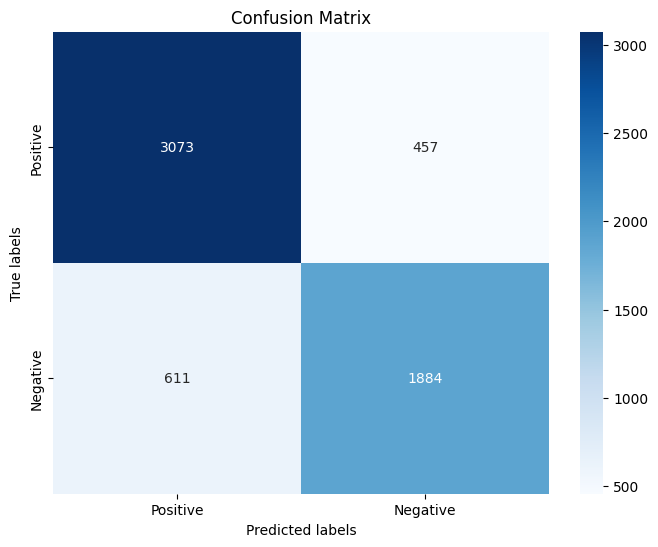

In [29]:
cm = confusion_matrix(y_test, y_result)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Positive', 'Negative'],
            yticklabels=['Positive', 'Negative'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [30]:
# Menghitung akurasi pelatihan
train_accuracy_rf = model.score(x_train, y_train)

# Memprediksi label untuk data uji
y_pred = model.predict(x_test)

validation_accuracy_rf = accuracy_score(y_test, y_pred)

print(f'\nAkurasi Pelatihan Random Forest: {train_accuracy_rf:.2f}')
print(f'Akurasi Validasi Random Forest: {validation_accuracy_rf:.2f}')


Akurasi Pelatihan Random Forest: 1.00
Akurasi Validasi Random Forest: 0.82


In [31]:
import pickle

# Simpan model ke file
with open('random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Simpan vectorizer
with open('vectorizer.pkl', 'wb') as vec_file:
    pickle.dump(vec, vec_file)

# Simpan tfidf transformer
with open('tfidf_transformer.pkl', 'wb') as tfidf_file:
    pickle.dump(tfidf, tfidf_file)

In [34]:
from flask import Flask, request, jsonify
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Load model
with open('random_forest_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

# Load vectorizer and tfidf transformer
with open('vectorizer.pkl', 'rb') as vec_file:
    vec = pickle.load(vec_file)

with open('tfidf_transformer.pkl', 'rb') as tfidf_file:
    tfidf = pickle.load(tfidf_file)

app = Flask(__name__)

@app.route('/', methods=['GET'])
def cek():
  return jsonify("sukses")
@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    text = data['text']

    # Transform input text
    x_vec = vec.transform([text])
    tfidf_data = tfidf.transform(x_vec)

    # Predict sentiment
    prediction = model.predict(tfidf_data)
    sentiment = 'positif' if prediction[0] == 1 else 'negatif'

    return jsonify({'sentiment': sentiment})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1